# 강남역 맛집 리뷰로 알아보는 감성 분류

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 카카오맵 리뷰 크롤링 

### [카카오맵 개발자도구 화면]

![앱 생성 페이지](img/1.png)

-----

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

# brew 로 설치된 chromedriver의 path (Mac)
path = '/usr/local/bin/chromedriver'

# 윈도우용 크롬 웹드라이버 실행 경로 (Windows)
excutable_path = 'chromedriver.exe'

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://map.kakao.com/"

# 크롬 드라이버를 사용합니다 (맥은 첫 줄, 윈도우는 두번째 줄 실행)
# driver = webdriver.Chrome(path)
driver = webdriver.Chrome(executable_path=excutable_path)

# 카카오 지도에 접속합니다
driver.get(source_url)

# 검색창에 검색어를 입력합니다
searchbox = driver.find_element_by_xpath("//input[@id='search.keyword.query']")
searchbox.send_keys("강남역 고기집")

# 검색버튼을 눌러서 결과를 가져옵니다
searchbutton = driver.find_element_by_xpath("//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

# 검색 결과를 가져올 시간을 기다립니다
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옵니다
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱합니다
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

https://place.map.kakao.com/85570955
https://place.map.kakao.com/1503746075
https://place.map.kakao.com/95713992
https://place.map.kakao.com/741391811
https://place.map.kakao.com/2011092566
https://place.map.kakao.com/13573220
https://place.map.kakao.com/2062959414
https://place.map.kakao.com/1648266796
https://place.map.kakao.com/168079537
https://place.map.kakao.com/263830255
https://place.map.kakao.com/27238067
https://place.map.kakao.com/26431943
https://place.map.kakao.com/1780387311
https://place.map.kakao.com/1907052666
https://place.map.kakao.com/1052874675
https://place.map.kakao.com/1576421052


-----

### [맛집 리뷰 정보 크롤링]

![앱 생성 페이지](img/2.png)

-----

In [3]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# driver = webdriver.Chrome(path)  # for Mac
driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
for page_url in page_urls:
    
    # 상세보기 페이지에 접속합니다
    driver.get(page_url)
    time.sleep(2)
    
    # 첫 페이지 리뷰를 크롤링합니다
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    # 별점을 가져옵니다.
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    # 리뷰를 가져옵니다.
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 2-5페이지의 리뷰를 크롤링합니다
    for button_num in range(2, 6):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않습니다.
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰를 크롤링합니다
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            # 별점을 가져옵니다.
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            # 리뷰를 가져옵니다.
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [4]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(374, 3)


,score,review,y
0,1,"예약할 때는 룸을 주기로 하고 홀을 주고, 덥고, 직원들이 정신이 없어 그 가격에 ...",0
1,5,점심식사 잘했던곳.후식커피한잔 하기도 좋고 주차가능합니다. 음식 맛있고 직원분 친절...,1
2,5,新鮮でおいしいです。,1
3,4,녹는다 녹아,1
4,4,,1


In [5]:
df.to_csv("review_data.csv", index=False)

-----

# <Step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### [형태소 추출하기]

##### 한글 텍스트로 전처리

In [2]:
df = pd.read_csv("review_data.csv")
df.head()

,score,review,y
0,1,"예약할 때는 룸을 주기로 하고 홀을 주고, 덥고, 직원들이 정신이 없어 그 가격에 ...",0
1,5,점심식사 잘했던곳.후식커피한잔 하기도 좋고 주차가능합니다. 음식 맛있고 직원분 친절...,1
2,5,新鮮でおいしいです。,1
3,4,녹는다 녹아,1
4,4,NaN,1


In [3]:
df.dropna(inplace=True)

In [4]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [5]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
0,1,0,예약할 때는 룸을 주기로 하고 홀을 주고 덥고 직원들이 정신이 없어 그 가격에 내가...
1,5,1,점심식사 잘했던곳후식커피한잔 하기도 좋고 주차가능합니다 음식 맛있고 직원분 친절하여...
3,4,1,녹는다 녹아
5,5,1,흠잡을곳 없는 반찬이 정갈합니다
6,5,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...


-----

##### 형태소 단위로 추출

In [6]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'].values[0])
print(result)

['예약/Noun', '할/Verb', '때/Noun', '는/Josa', '룸/Noun', '을/Josa', '주기/Noun', '로/Josa', '하고/Verb', '홀/Noun', '을/Josa', '주고/Verb', '덥고/Adjective', '직원/Noun', '들/Suffix', '이/Josa', '정신/Noun', '이/Josa', '없어/Adjective', '그/Noun', '가격/Noun', '에/Josa', '내/Noun', '가/Josa', '직접/Noun', '구워/Verb', '먹고/Verb', '갈비살/Noun', '등심/Noun', '은/Josa', '질/Noun', '기고/Noun', '냉면/Noun', '은/Josa', '맛/Noun', '이/Josa', '없고/Adjective', '장어/Noun', '양념/Noun', '들/Suffix', '도/Josa', '제/Noun', '때/Noun', '안/Noun', '가져다/Verb', '주고/Verb', '회식/Noun', '으로/Josa', '한/Determiner', '시간/Noun', '만에/Josa', '만원/Noun', '을/Josa', '썼는데/Verb', '이런/Adjective', '경험/Noun', '처음/Noun', '입니다/Adjective']


-----

### [분류 모델의 학습 데이터로 변환하기]

##### corpus index 생성하기

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [8]:
X.shape

(307, 2402)

In [9]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'예약/Noun': 1573, '할/Verb': 2297, '때/Noun': 684, '는/Josa': 484, '룸/Noun': 718, '을/Josa': 1674, '주기/N..


In [13]:
print(df['ko_text'].values[0])
print(X[0])

예약할 때는 룸을 주기로 하고 홀을 주고 덥고 직원들이 정신이 없어 그 가격에 내가 직접 구워먹고 갈비살 등심은 질기고 냉면은 맛이 없고 장어 양념들도 제 때 안 가져다 주고 회식으로 한시간만에 만원을 썼는데 이런 경험 처음입니다
  (0, 1573)	1
  (0, 2297)	1
  (0, 684)	2
  (0, 484)	1
  (0, 718)	1
  (0, 1674)	3
  (0, 1961)	1
  (0, 713)	1
  (0, 2235)	1
  (0, 2361)	1
  (0, 1959)	2
  (0, 572)	1
  (0, 2009)	1
  (0, 649)	2
  (0, 1688)	3
  (0, 1897)	1
  (0, 1512)	1
  (0, 255)	1
  (0, 34)	1
  (0, 1528)	1
  (0, 419)	1
  (0, 29)	1
  (0, 2010)	1
  (0, 220)	1
  (0, 828)	1
  (0, 83)	1
  (0, 671)	1
  (0, 1673)	2
  (0, 2013)	1
  (0, 297)	1
  (0, 429)	1
  (0, 769)	1
  (0, 1497)	1
  (0, 1833)	1
  (0, 1459)	1
  (0, 581)	1
  (0, 1900)	1
  (0, 1388)	1
  (0, 67)	1
  (0, 2374)	1
  (0, 1668)	1
  (0, 2282)	1
  (0, 1264)	1
  (0, 747)	1
  (0, 748)	1
  (0, 1336)	1
  (0, 1707)	1
  (0, 168)	1
  (0, 2077)	1
  (0, 1776)	1


-----

##### TF-IDF로 변환

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [15]:
print(X.shape)
print(X[0])

(307, 2402)
  (0, 2374)	0.12468533189681041
  (0, 2361)	0.1549047470856822
  (0, 2297)	0.12178719103308726
  (0, 2282)	0.12792517773998868
  (0, 2235)	0.1408535192112757
  (0, 2077)	0.11916550372361367
  (0, 2013)	0.12178719103308726
  (0, 2010)	0.12792517773998868
  (0, 2009)	0.08041468883353213
  (0, 1961)	0.16605783409636554
  (0, 1959)	0.2817070384225514
  (0, 1900)	0.12792517773998868
  (0, 1897)	0.13583841890749376
  (0, 1833)	0.16605783409636554
  (0, 1776)	0.10413178222608263
  (0, 1707)	0.1408535192112757
  (0, 1688)	0.17132446129740309
  (0, 1674)	0.2619827068640185
  (0, 1673)	0.13893223002224944
  (0, 1668)	0.09346555566157425
  (0, 1573)	0.11916550372361367
  (0, 1528)	0.06196651918904839
  (0, 1512)	0.1549047470856822
  (0, 1497)	0.11253188383976268
  (0, 1459)	0.1315982120179511
  (0, 1388)	0.11457036420487282
  (0, 1336)	0.16605783409636554
  (0, 1264)	0.11677209072930533
  (0, 828)	0.11063410402240391
  (0, 769)	0.06865703029713122
  (0, 748)	0.13583841890749376
  (0, 

-----

# <Step3. 분류> : 긍정 부정 리뷰 분류하기

### [분류 모델링]

##### 데이터셋 분리

In [16]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(214, 2402)
(93, 2402)


-----

##### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.63
Precision : 0.607
Recall : 0.981
F1 : 0.750


In [18]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 8 33]
 [ 1 51]]


AUC : 0.793


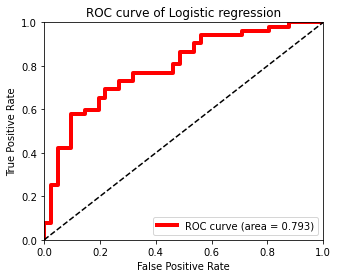

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

------

# <Step4. 활용> : 중요 키워드 분석

### [회귀 모델의 피처 영향력 추출]

<BarContainer object of 2402 artists>

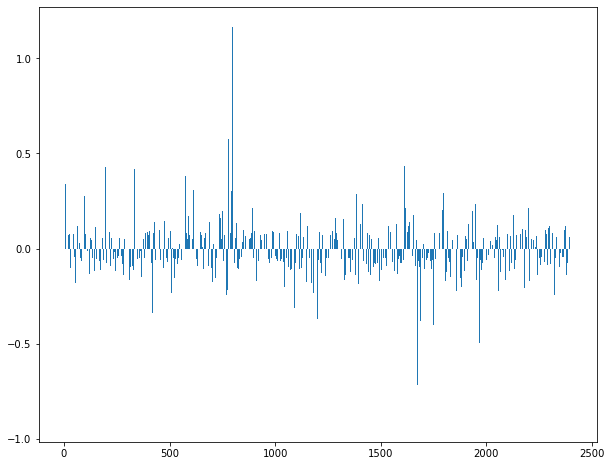

In [20]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [21]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.1661694987277493, 798), (0.7477020749065132, 2091), (0.7264480935696059, 1917), (0.6491998980561823, 804), (0.5781798174317825, 779)]
[(-0.6817768497305661, 260), (-0.6959068726140512, 913), (-0.7192438344387652, 1674), (-0.8350569659056502, 1673), (-0.9120324047931752, 1528)]


-----

### [중요 피처의 형태소]

In [22]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [23]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{1573: '예약/Noun', 2297: '할/Verb', 684: '때/Noun', 484: '는/Josa', 718: '룸/Noun', 1674: '을/Josa', 1961:..


In [24]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛있어요/Adjective 1.1661694987277493
최고/Noun 0.7477020749065132
존맛/Noun 0.7264480935696059
맛있음/Adjective 0.6491998980561823
맛있고/Adjective 0.5781798174317825
ㅎㅎ/KoreanParticle 0.5010533788009287
좋네요/Adjective 0.48387594373061177
맛있게/Adjective 0.4504362127956085
완전/Noun 0.4364557901168961
곱/Noun 0.4276646905221411
깔끔하고/Adjective 0.4197128715898068
맛있네요/Adjective 0.40273953813180635
밥/Noun 0.38901308067260354
덮/Verb 0.380084247087381
ㅋㅋ/KoreanParticle 0.3372073274883319
ㅎ/KoreanParticle 0.33659257879438104
거기/Noun 0.3232263433048465
치즈/Noun 0.3161466725853445
도/Josa 0.3098591289048778
된장찌개/Noun 0.30942571458963325


In [26]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

불친절함/Adjective -0.43874773295084846
그닥/Noun -0.4590242258407223
좀/Noun -0.4871315356928096
진짜/Noun -0.4919751289302193
말/Noun -0.49539008968413595
주문/Noun -0.4963419257918371
별로/Noun -0.5308672634795573
는/Josa -0.5347907807305746
대비/Noun -0.5601673408735989
없고/Adjective -0.585941384669529
점/Noun -0.5984136437310353
최악/Noun -0.6041073602504622
가/Josa -0.6221348051469782
안/VerbPrefix -0.6275831895783829
곱창/Noun -0.65968458878457
그냥/Noun -0.6817768497305661
무난/Noun -0.6959068726140512
을/Josa -0.7192438344387652
은/Josa -0.8350569659056502
에/Josa -0.9120324047931752


-----

In [140]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [141]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('최고/Noun', 2.005692293233956),
 ('존맛/Noun', 0.6023446715957659),
 ('강남/Noun', 0.4956664193460228),
 ('곱/Noun', 0.4681650757238441),
 ('음식/Noun', 0.43496099861299975),
 ('추천/Noun', 0.3892574644699166),
 ('곳/Noun', 0.3854982871631295),
 ('육즙/Noun', 0.37025678991594896),
 ('맛있댜/Noun', 0.35279620545500545),
 ('맛맛/Noun', 0.35279620545500545)]

In [142]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('좋아요/Adjective', 1.6692476943563863),
 ('맛있어요/Adjective', 1.0870064528652426),
 ('맛있고/Adjective', 0.9657684076470117),
 ('맛있음/Adjective', 0.7276255745083494),
 ('좋은/Adjective', 0.5151186773211861),
 ('깔끔하고/Adjective', 0.4740556266941344),
 ('맛있게/Adjective', 0.461363298132383),
 ('맛있네요/Adjective', 0.4593403243374981),
 ('친절하고/Adjective', 0.45633479961768425),
 ('있으나/Adjective', 0.3686146498936071)]

Copyright (c) 2019 [윤기태]


https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)